In [1]:
pip install ultralytics opencv-python numpy scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from ultralytics import YOLO
import cv2
import numpy as np
from sklearn.cluster import KMeans
from google.colab.patches import cv2_imshow
import glob, os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
folder_path = "/content/drive/MyDrive/Deep-Learning-Computer-Vision-Final-Project/deepLearningPictures/deeplearning"

In [5]:
image_paths = glob.glob(folder_path + "/*.png")
print("Found", len(image_paths), "images")

Found 14 images


In [6]:
from google.colab.patches import cv2_imshow
for img_path in image_paths:
    img = cv2.imread(img_path)
    cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
yolo_model = YOLO("yolov8n.pt")
PERSON_CLASS_ID = 0

In [8]:
def detect_players(img_bgr, model):
    results = model(img_bgr, verbose=False)[0]
    boxes = []
    for box in results.boxes:
        cls = int(box.cls[0])
        if cls == PERSON_CLASS_ID:
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            boxes.append([int(x1), int(y1), int(x2), int(y2)])
    return boxes


In [9]:
def get_jersey_color_features(img_bgr, boxes):
    feats = []
    for (x1, y1, x2, y2) in boxes:
        crop = img_bgr[y1:y2, x1:x2]
        if crop.size == 0:
            feats.append([0,0,0])
            continue
        # take upper half = jersey area
        h = crop.shape[0]
        jersey = crop[0:int(h*0.6), :, :]
        jersey_hsv = cv2.cvtColor(jersey, cv2.COLOR_BGR2HSV)
        mean_hsv = jersey_hsv.reshape(-1, 3).mean(axis=0)
        feats.append(mean_hsv)
    return np.array(feats, dtype=np.float32)

def cluster_teams(img_bgr, boxes):
    """
    Return team_labels: 0 or 1 for each box.
    """
    if len(boxes) == 0:
        return np.array([])
    feats = get_jersey_color_features(img_bgr, boxes)
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
    team_labels = kmeans.fit_predict(feats)
    return team_labels


In [10]:
def get_normalized_positions(boxes, team_labels, team_id, img_shape):
    h, w = img_shape[:2]
    xs, ys = [], []
    for (box, t) in zip(boxes, team_labels):
        if t != team_id:
            continue
        x1, y1, x2, y2 = box
        xc = (x1 + x2) / 2.0
        yc = (y1 + y2) / 2.0
        xs.append(xc / w)
        ys.append(yc / h)
    xs, ys = np.array(xs), np.array(ys)
    return xs, ys

def infer_formation(xs, ys, k_lines=3):
    n = len(xs)
    if n < k_lines:
        return "Too few players"

    ys_reshape = ys.reshape(-1, 1)
    km = KMeans(n_clusters=k_lines, random_state=0, n_init=10)
    line_labels = km.fit_predict(ys_reshape)

    # sort lines from deepest (largest y) to highest (smallest y)
    line_centers = km.cluster_centers_.flatten()
    order = np.argsort(line_centers)  # 0 = back line

    counts = []
    for idx in order:
        counts.append(int((line_labels == idx).sum()))

    formation_str = "-".join(str(c) for c in counts)
    return formation_str


In [11]:
def detect_anomaly(xs, ys):
    if len(xs) == 0:
        return True, "No players"

    spread_x = xs.max() - xs.min()
    spread_y = ys.max() - ys.min()
    spread_area = spread_x * spread_y

    # simple thresholds – tune if needed
    if spread_area < 0.05:
        return True, "Crowded / set-piece-like"
    return False, "Normal"


In [12]:
def analyze_frame(img_bgr, model, team_id=0, k_lines=3):
    boxes = detect_players(img_bgr, model)
    team_labels = cluster_teams(img_bgr, boxes)
    if len(team_labels) == 0:
        return img_bgr, "No players"

    xs, ys = get_normalized_positions(boxes, team_labels, team_id, img_bgr.shape)

    is_anom, anom_msg = detect_anomaly(xs, ys)
    if is_anom:
        formation = f"Anomaly: {anom_msg}"
    else:
        formation = infer_formation(xs, ys, k_lines=k_lines)

    # draw boxes (team 0 blue, team 1 red)
    vis = img_bgr.copy()
    for (box, t) in zip(boxes, team_labels):
        x1, y1, x2, y2 = box
        color = (255, 0, 0) if t == 0 else (0, 0, 255)
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)

    # put text on top
    cv2.putText(vis, f"Team {team_id} formation: {formation}",
                (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2, cv2.LINE_AA)
    return vis, formation


Predicted: 4-3-3


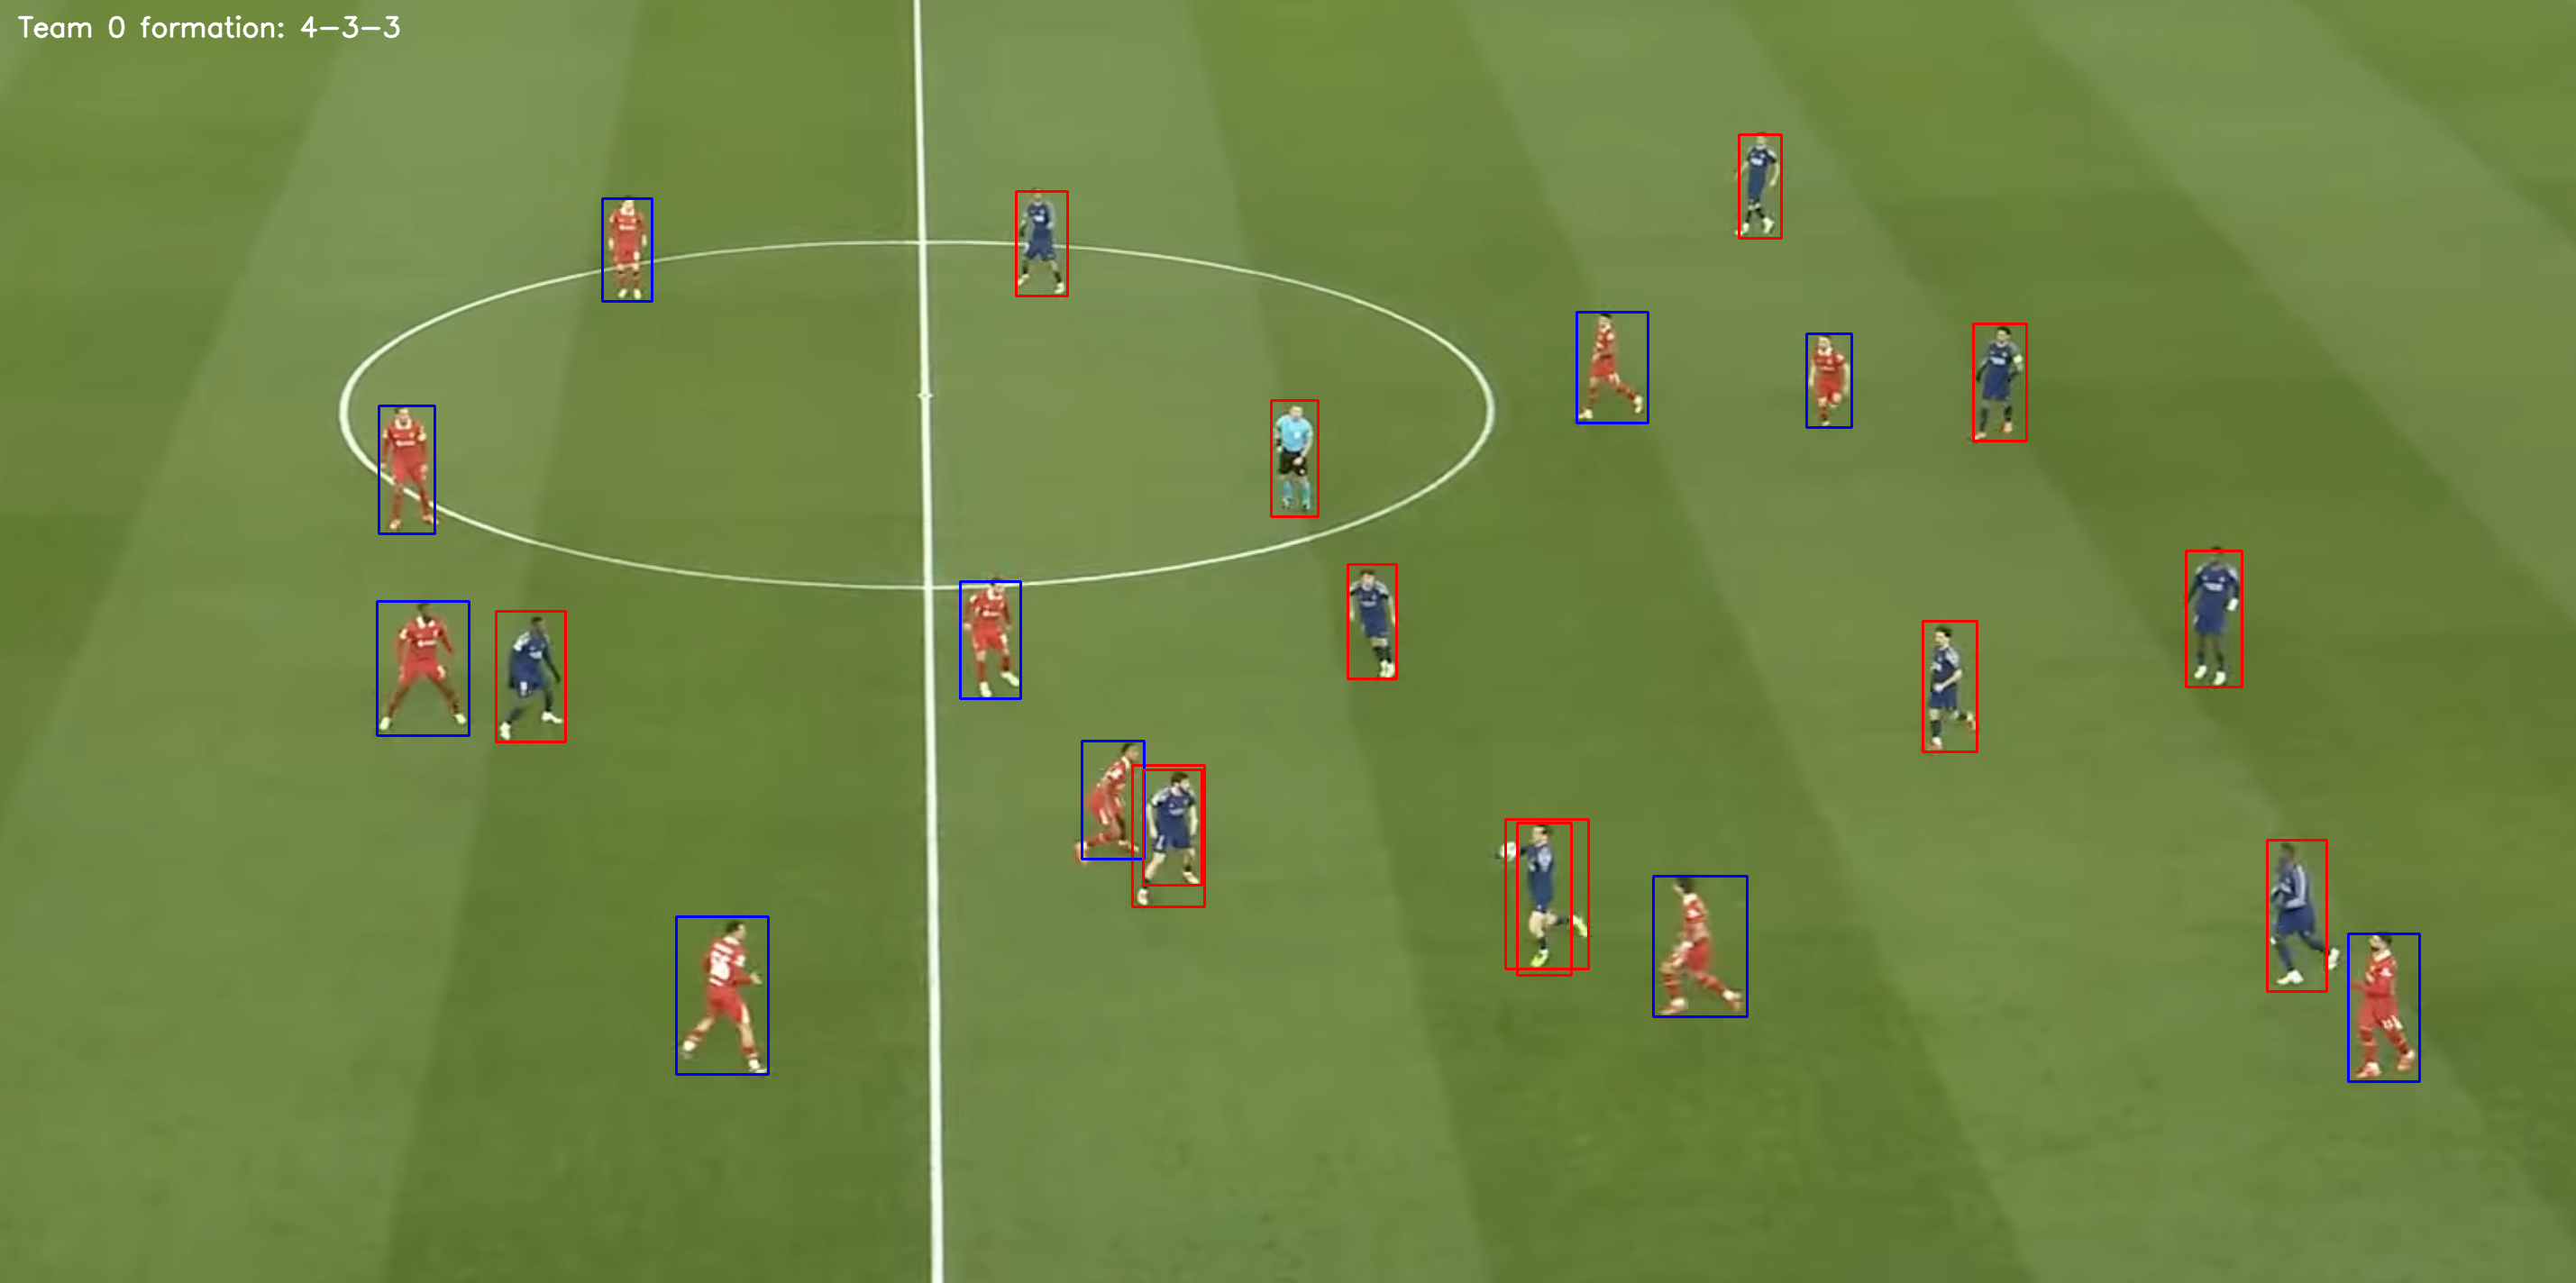

In [13]:
test_path = image_paths[2]
img = cv2.imread(test_path)

vis, formation = analyze_frame(img, yolo_model, team_id=0, k_lines=3)
print("Predicted:", formation)
cv2_imshow(vis)


In [14]:
for p in image_paths:
    img = cv2.imread(p)
    vis, formation = analyze_frame(img, yolo_model, team_id=0, k_lines=3)
    print(os.path.basename(p), "->", formation)
    cv2_imshow(vis)


Output hidden; open in https://colab.research.google.com to view.


0: 256x640 23 persons, 179.9ms
Speed: 6.2ms preprocess, 179.9ms inference, 5.4ms postprocess per image at shape (1, 3, 256, 640)
Total boxes: 23
Classes in boxes: [          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0]


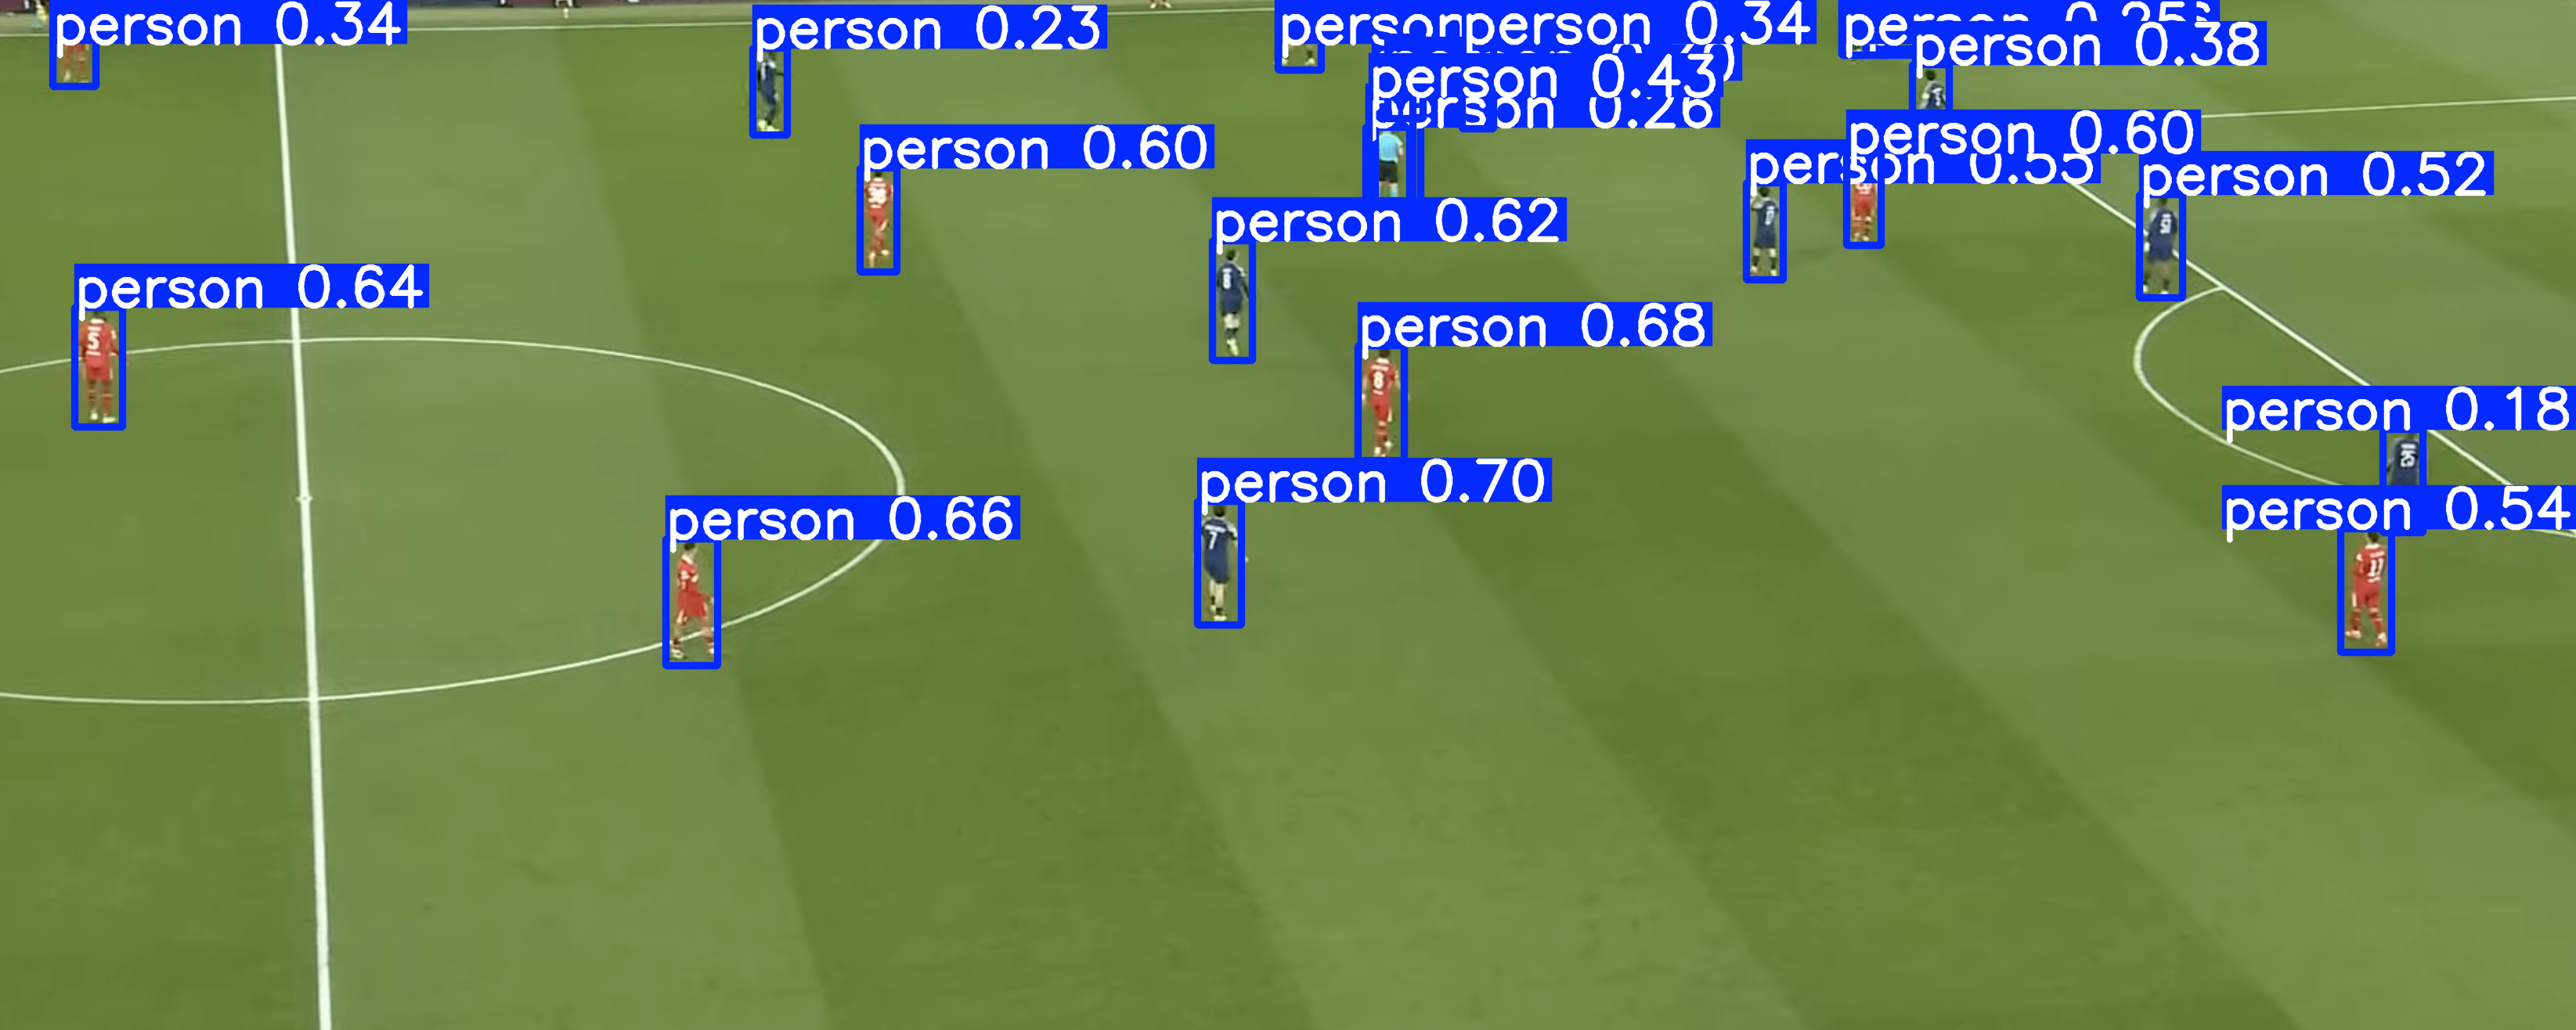

In [15]:
model = yolo_model

results = model(img, conf=0.10, verbose=True)   # lower conf
res = results[0]
print("Total boxes:", len(res.boxes))
print("Classes in boxes:", res.boxes.cls.cpu().numpy() if len(res.boxes) else "none")

annotated = res.plot()
cv2_imshow(annotated)


In [16]:
def team_pos_stats(xs, ys, k_lines=3):
    """
    xs, ys are normalized coords for one team.
    Returns dict with formation, mean depth, vertical compactness.
    """
    n = len(xs)
    if n < max(4, k_lines):
        return {
            "valid": False,
            "formation": "unknown",
            "mean_y": None,
            "spread_y": None,
        }

    mean_y = float(ys.mean())
    spread_y = float(ys.max() - ys.min())

    formation = infer_formation(xs, ys, k_lines=k_lines)
    return {
        "valid": True,
        "formation": formation,
        "mean_y": mean_y,
        "spread_y": spread_y,
    }


In [17]:
def describe_team_role(team_id, stats, role):
    """
    role = 'attacking' or 'defending'
    """
    form = stats["formation"]
    mean_y = stats["mean_y"]
    spread_y = stats["spread_y"]

    # depth description (assuming y=0 top, y=1 bottom)
    if mean_y is None:
        depth = "with an unclear shape"
    elif mean_y < 0.35:
        depth = "holding a fairly high line"
    elif mean_y < 0.65:
        depth = "set up in a mid-block"
    else:
        depth = "sitting quite deep in their own half"

    # compactness
    if spread_y is None:
        compact = ""
    elif spread_y < 0.20:
        compact = " in a very compact block"
    elif spread_y < 0.35:
        compact = " with the lines reasonably close together"
    else:
        compact = " with the team stretched vertically between the lines"

    if role == "attacking":
        prefix = f"Team {team_id} are in possession, roughly in a {form} shape,"
        suffix = " looking to occupy advanced zones."
    else:
        prefix = f"Team {team_id} are out of possession in about a {form} structure,"
        suffix = " mainly focused on protecting space and closing passing lanes."

    return prefix + " " + depth + compact + suffix


In [18]:
def analyze_frame_both(img_bgr, model, k_lines=3):
    boxes = detect_players(img_bgr, model)          # your existing function
    if len(boxes) == 0:
        return img_bgr, "No players detected"

    team_labels = cluster_teams(img_bgr, boxes)     # 0 / 1 per box
    if len(team_labels) == 0:
        return img_bgr, "No teams found"

    vis = img_bgr.copy()

    # draw boxes: team 0 red, team 1 blue (same as your screenshot)
    for (box, t) in zip(boxes, team_labels):
        x1, y1, x2, y2 = box
        color = (0, 0, 255) if t == 0 else (255, 0, 0)   # BGR
        cv2.rectangle(vis, (x1, y1), (x2, y2), color, 2)

    # stats for both teams
    stats = {}
    for tid in [0, 1]:
        xs, ys = get_normalized_positions(boxes, team_labels, tid, img_bgr.shape)
        stats[tid] = team_pos_stats(xs, ys, k_lines=k_lines)

    # decide who is "more advanced" (lower mean_y = higher up the pitch)
    mean0, mean1 = stats[0]["mean_y"], stats[1]["mean_y"]
    if mean0 is None or mean1 is None:
        desc = "Not enough players per team to infer roles."
        cv2.putText(vis, desc, (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
        return vis, desc

    if mean0 < mean1:
        attacking_id, defending_id = 0, 1
    else:
        attacking_id, defending_id = 1, 0

    desc_att = describe_team_role(attacking_id, stats[attacking_id], "attacking")
    desc_def = describe_team_role(defending_id, stats[defending_id], "defending")

    # put short summary on the frame, full text you can print separately
    short_text = f"Team {attacking_id}: {stats[attacking_id]['formation']} (attacking), " \
                 f"Team {defending_id}: {stats[defending_id]['formation']} (defending)"
    cv2.putText(vis, short_text, (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

    full_description = desc_att + " " + desc_def
    return vis, full_description


In [19]:
for path in image_paths:
    img = cv2.imread(path)
    vis, text = analyze_frame_both(img, yolo_model, k_lines=3)

    print(os.path.basename(path), "->")
    print(text, "\n")
    cv2_imshow(vis)

Output hidden; open in https://colab.research.google.com to view.